# **Clustering -- Kmeans Algorithm**

## **PHASE OF THE CRISP-DM: BUSINESS UNDERSTANDING**

O problema consiste em agrupar os dados (pontos) com base na sua geolocalização (latitude e longitude) e respeitando as restrições.

Restrição:

1) Distância máxima de 1.6km entre os pontos e seu centróide.

## **PHASE OF THE CRISP-DM: DATA UNDERSTANDING**

Nesta etapa foi realizada a análise exploratória da base. Foi verificado como o dataset é apresentado, suas dimensões e a presença ou não de valores ausentes.  

In [1]:
# Importação das bibliotecas
# para manipulação dos dados
import numpy as np
import pandas as pd

# para os gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise geoespacial
import folium

# para machine learning
from sklearn import cluster
import scipy

In [2]:
# Leitura dos dados
dtf = pd.read_excel('dataset_geo2.xlsx')
dtf.head(5)

,Latitude,Longitude
0,-7.78417,-34.906820
1,-7.94198,-34.897218
2,-7.57838,-35.032610
3,-7.97718,-34.900890
4,-7.56779,-35.005590


In [3]:
# Verificação das dimensões do dataset
print('Apresentando a dimensão dos dados: {}'.format(dtf.shape))

# Verificação dos valores ausentes na base
print('Quantidade de valores ausentes:')
print(dtf.isnull().sum())

Apresentando a dimensão dos dados: (4814, 2)
Quantidade de valores ausentes:
Latitude     0
Longitude    0
dtype: int64


A partir dos dados acima, pode verificar que a base contém 4814 instâncias e 2 atributos. Além disso, a base não tem valores ausentes. 

## **PHASE OF THE CRISP-DM: DATA PREPARATION**

Nesta etapa foi realizada a preparação da base de dados. Assim, os pontos (coordenadas de latitude e longitude) foram plotados no mapa utilizando o pacote folium que permite traçar mapas iterativos.

In [4]:
# Definição das variáveis como a latitude e longitude do dataset
x, y = 'Latitude', 'Longitude'

# Fazendo uma cópia do dataframe
data = dtf.copy()

# Definindo o local de inicialização do mapa como a primeira linha do df
loc = data.iloc[0]

# Inicializa o mapa com o local de partida
map_ = folium.Map(location=loc, tiles='cartodbpositron', zoom_start=11)

# Adiciona um círculo no mapa para cada coordenada de latitude e longitude do dataset
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]],fill=True,
                                           popup = folium.Popup(str(['LAT',row[x],'LONG',row[y]]))).add_to(map_), axis=1)

# Plotagem do Mapa
map_

Output hidden; open in https://colab.research.google.com to view.

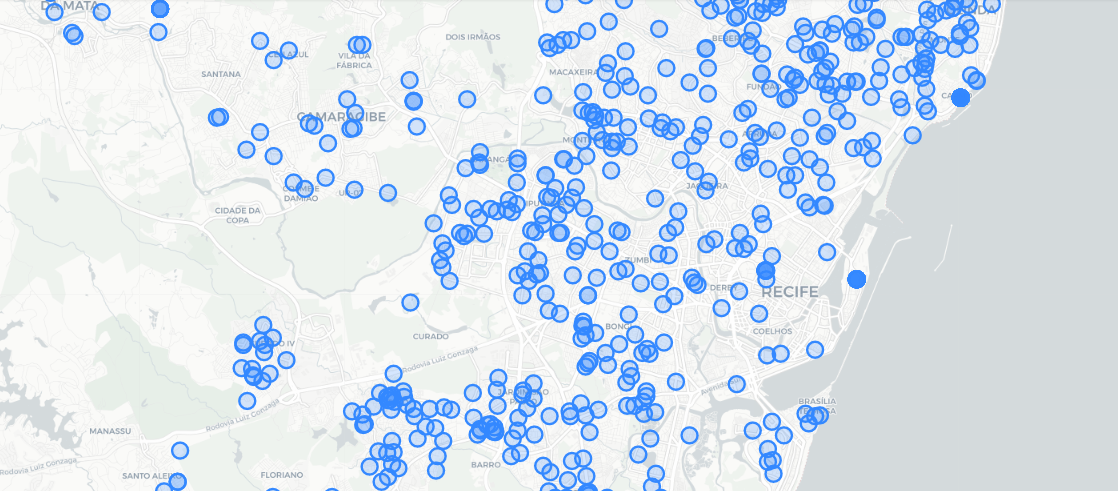

## **PHASE OF THE CRISP-DM: MODELING**

Nesta etapa foi realizado o agrupamento de modo a encontrar os grupos de pontos próximos e seus centróides respeitando a restrição de 0,8km. O algoritmo Kmeans foi utilizado.

**CLUSTERING - ALGORITMO: K-MEANS**

Este algoritmo divide os pontos em um número pré-definido de clusters (k), em que cada ponto pertencente ao cluster com a média mais próxima, portanto a restrição de 0.8km não é um parâmetro do algoritmo.

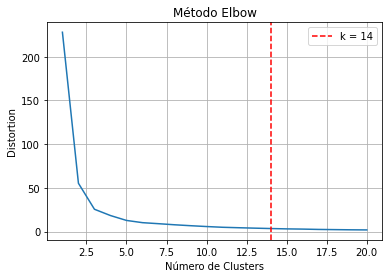

In [5]:
# Método Elbow
# Definindo o valor máximo de clusters = 20
max_k = 20 

# Fazendo uma cópia do dataframe
X = dtf.copy()

# Iterações realizadas no algoritmo K-Means
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_) 
       # A cada iteração, adiciona-se o somatório dos erros quadráticos das instâncias de cada cluster ao array distortions

# Melhor valor de k é o que possui a derivada mais próxima de 0
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

# Plotagem do gráfico do Método Elbow
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color='red', label='k = '+str(k)) 
ax.set(title='Método Elbow', xlabel='Número de Clusters', ylabel='Distortion')
ax.legend()
ax.grid(True)
plt.show()

O algoritmo do K-Means foi executado 20 vezes cada uma com 300 iterações
Segundo o Método Elbow, que testa a variância dos dados em relação ao número de clusters, o melhor valor foi k=14. Entretanto para esse projeto não faz sentido apenas 14 clusters, então foi realizada uma nova modelagem com k=400.


In [6]:
# Definindo o número de clusters = 400
k = 400

# Fazendo uma cópia do dataframe
X = dtf.copy()

# Clusterização
model = cluster.KMeans(n_clusters=k, init='k-means++')
X['cluster'] = model.fit_predict(X)

# Identificando os verdadeiros centróides
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, X.drop('cluster', axis=1).values)
X['centroids'] = 0
for i in closest:
    X['centroids'].iloc[i] = 1

# Adicionando informações de cluster e centróides ao dataset original
dtf[['Cluster','Centróides']] = X[['cluster','centroids']]
dtf.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Latitude,Longitude,Cluster,Centróides
0,-7.78417,-34.906820,258,0
1,-7.94198,-34.897218,348,0
2,-7.57838,-35.032610,56,0
3,-7.97718,-34.900890,126,0
4,-7.56779,-35.005590,222,0


Foram adicionadas duas colunas ao dataset, onde:
- a coluna "Cluster" indica a que grupo o ponto pertence
- a coluna "Centróides" indica 1 se o ponto também é o centróide (o mais próximo do centro) e 0 se não.

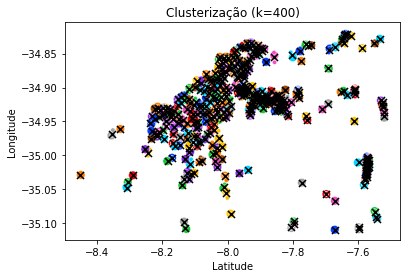

In [7]:
# Plotagem da Clusterização "x" representa o centróide
fig, ax = plt.subplots()
sns.scatterplot(x='Latitude', y='Longitude', data=dtf, palette=sns.color_palette('bright',k), hue='Cluster', size='Centróides', size_order=[1,0],
                legend= False, ax=ax).set_title('Clusterização (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker='x')

Este gráfico representa a Clusterização e a definição dos 400 centróides realizada pelo algoritmo K-Means, baseando-se nas latitudes e longitudes.

In [8]:
# Exibição dos Clusters no mapa
x, y = 'Latitude', 'Longitude'
color = 'Cluster'
marker = 'Centróides'
data = dtf.copy()

# Definindo a cor dos clusters
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# Inicialização do mapa com o local de partida
map_ = folium.Map(location=loc, tiles='cartodbpositron',zoom_start=11)

# Adicionar os pontos da base de dados ao mapa, através da latitude e longitude
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], color=row['color'],
                                           popup = folium.Popup(str(['LAT',row[x],'LONG',row[y]])),
                                           fill=True).add_to(map_), axis=1)

# Adicionando a marcação dos centróides
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: folium.Marker(location=[row[x],row[y]], icon=folium.Icon(color='black')).add_to(map_), axis=1)

# Plota e salva como html
map_.save('clustering_kmeans.html')
print('O mapa foi criado. Salvo como clustering_kmeans.html.')
map_

Output hidden; open in https://colab.research.google.com to view.

A partir do algoritmo K-Means para agrupamento dos pontos, foi gerado o mapa com a visualização dos clusters (separados por cor) e exibição dos centróides (ícones pretos).

O algoritmo K-Means gerou uma adequada distribuição dos centróides, porém foi necessário definir inicialmente o valor de k (número de clusters). Além disso, não foi possível atender a restrição de distância 1.6km já que o algoritmo não possui este tipo de parâmetro.

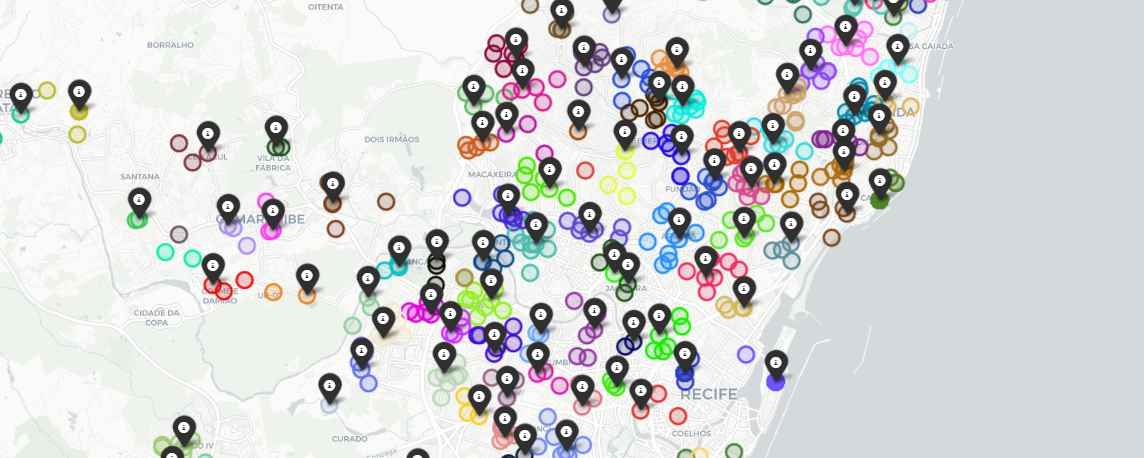